In [1]:
subj = 'UI399'
root_dir = '/Users/alia/Documents/mandarin'

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from os.path import join, exists
from os import makedirs
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fftpack
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from sklearn.preprocessing import scale
import random
import librosa

In [3]:
# Create directories
fdir = root_dir + '/mandarin_ffr/fig/' + subj
odir = root_dir + '/output/' + subj

if not exists(fdir):
    makedirs(fdir)
if not exists(odir):
    makedirs(odir)

## Read Data

In [4]:
# Where are the data?
dir_data = ''.join([root_dir, '/', subj, '/data'])
file_ECoG = ''.join([dir_data, '/', subj, '_dat_FFR_noCAR_notch_hp_allTrials.mat'])
# file_ECoG = ''.join([dir_data, '/', subj, '_dat_FFR.mat'])

# Load the .mat file
f = h5py.File(file_ECoG, 'r')

# Read ECoG data
hg_stim = np.array(f['dat']['hg_stim']) # trial * tp * ch
badChans = f['dat']['badChans'].value.flatten() - 1 # Correct for 0-indexing
time_axis = (np.round(f['dat']['time_axis'].value.flatten(), 3) * 1000).astype(int) # Use int b/c float precision

# Import behav
list_col = ['accuracy', 'block', 'choice', 'rt', 'speaker', 'syllable', 'tone', 'trial']
behav = pd.DataFrame(columns = list_col)
for icol in list_col:
    if np.in1d(icol, ['speaker', 'syllable']):
        for i in range(0, behav.shape[0]):
            behav.loc[i, icol] = ''.join(map(chr, f[f['dat']['behav'][icol][0,i]]))
    else:
        behav[icol] = np.array(f['dat']['behav'][icol]).flatten()
        
for icol in ['accuracy', 'block', 'choice', 'tone', 'trial']:
    behav[icol] = behav[icol].astype(int)
    
f.close()

#extract data from 0-500 ms 


# Get rid of NaN trials, if any
if np.in1d(subj, ['EC157','EC159', 'UI399']):
    nanTrial = np.unique(np.where(np.isnan(hg_stim))[0])
    if nanTrial.shape[0] > 0: # perform only if NaN trials exist at all
        hg_stim = np.delete(hg_stim, nanTrial, 0)
        behav = behav.drop(nanTrial, axis = 0).reset_index(drop = True)

# What are the "good" channels?
good_ch_vector = np.ones((hg_stim.shape[2])).astype(int)
good_ch_vector[badChans] = 0
goodChans = np.where(good_ch_vector)[0]
    
# Create index for behav (not literally the trial)
behav['Trial'] = range(0, behav.shape[0])

# Add the "file" column
behav['file'] = behav['syllable'].astype(str) + behav['tone'].astype(str) + '-' + behav['speaker'].astype(str) + 'N'

## Autocorr

In [5]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    #"full" mode returns results for every t where both a and v have some overlap.
    #"same" mode returns a result with the same length as the shortest vector (a or v).
    #"valid" mode returns results only when a and v completely overlap each other. The documentation for numpy.convolve gives more detail on the modes.
    return result[result.size/2:]

## Read Stim files and run autocorr with 60 ms delay

In [6]:
## get list of tones
tones = np.unique(behav['file'])
tones = tones.tolist()

In [27]:
##read wav file 
## data2 = autocorr dataframe

'''this reads each wav file, zero pads it to match the FFR, runs autocorr on all stimuli and then 
    normalizing from -1 to 1'''
import scipy.io
import os

'''autocorr the stimulation wav files t = tone, p = b or h, male or female'''
dirs = os.listdir('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/')
tone = []
files = []
lists = []
tones = []
# start = 0
# end = 50
positive = np.zeros((558,))
negative = np.zeros((500,))

data2 = pd.DataFrame()
dataLag = pd.DataFrame()
# dataLag['1/lag'] = np.zeros(76)
# dataLag['max'] = np.zeros(76)

# print(d.shape)
for i in dirs:
    y, sr= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000) ##changes the sr to 1000
    a= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000) ##changes the sr to 1000
    y = np.append(y,positive)
    y = np.insert(y,0,negative)
    start = 0 
    end = 80
    cor = np.zeros((72,80))
    d = np.zeros((72,80))
    dataLag[i] = np.zeros(76)
    lag = []
    #separate the data into times
    for x in range(70):
        index = list(range(start,end))
        d[x,:] = y[index]        
        end += 20
        start += 20 

    # # do autocorr on all bins 
    for bins in range(0,d.shape[0]): 
        cor[bins,:] = autocorr(d[bins,:])
    data2[i] = np.zeros(71)
    maxs = []
    lags1 = []
    for bins in range(1,cor.shape[0]): 
        maxx = max(cor[bins,:])
        lags = np.where(cor[bins] == maxx)[0]
#         lags = np.array(lags).tolist()
        maxs.append(maxx)
#     dataLag[i] = 1/lags

    for j in range(0,cor.shape[0]):
        nozero = cor[j,2:15]
        maxes = max(nozero)
        for time in range(2,15):
            if cor[j,time] == maxes:
                dataLag[i][j] = 1/time
#                 dataLag['max_' + str(i)][j] = cor[j,time]
    norms = []
    for m in maxs:
        high = max(maxs)
        low = min(maxs)
        n = 2*((m-low)/(high-low)) - 1
        norms.append(n)
    data2[i] = norms
#     data2[i] = maxs
dataBin = pd.DataFrame()
a = [x for x in range(len(dataLag))]
dataBin['bin'] = a 

#     test.append(y)
#     f,t, Sxx = signal.spectrogram(y, sr, noverlap = 76, nperseg =90)
#     Sxx = np.array(Sxx).tolist()
#     tones.append(Sxx)

/Users/alia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  


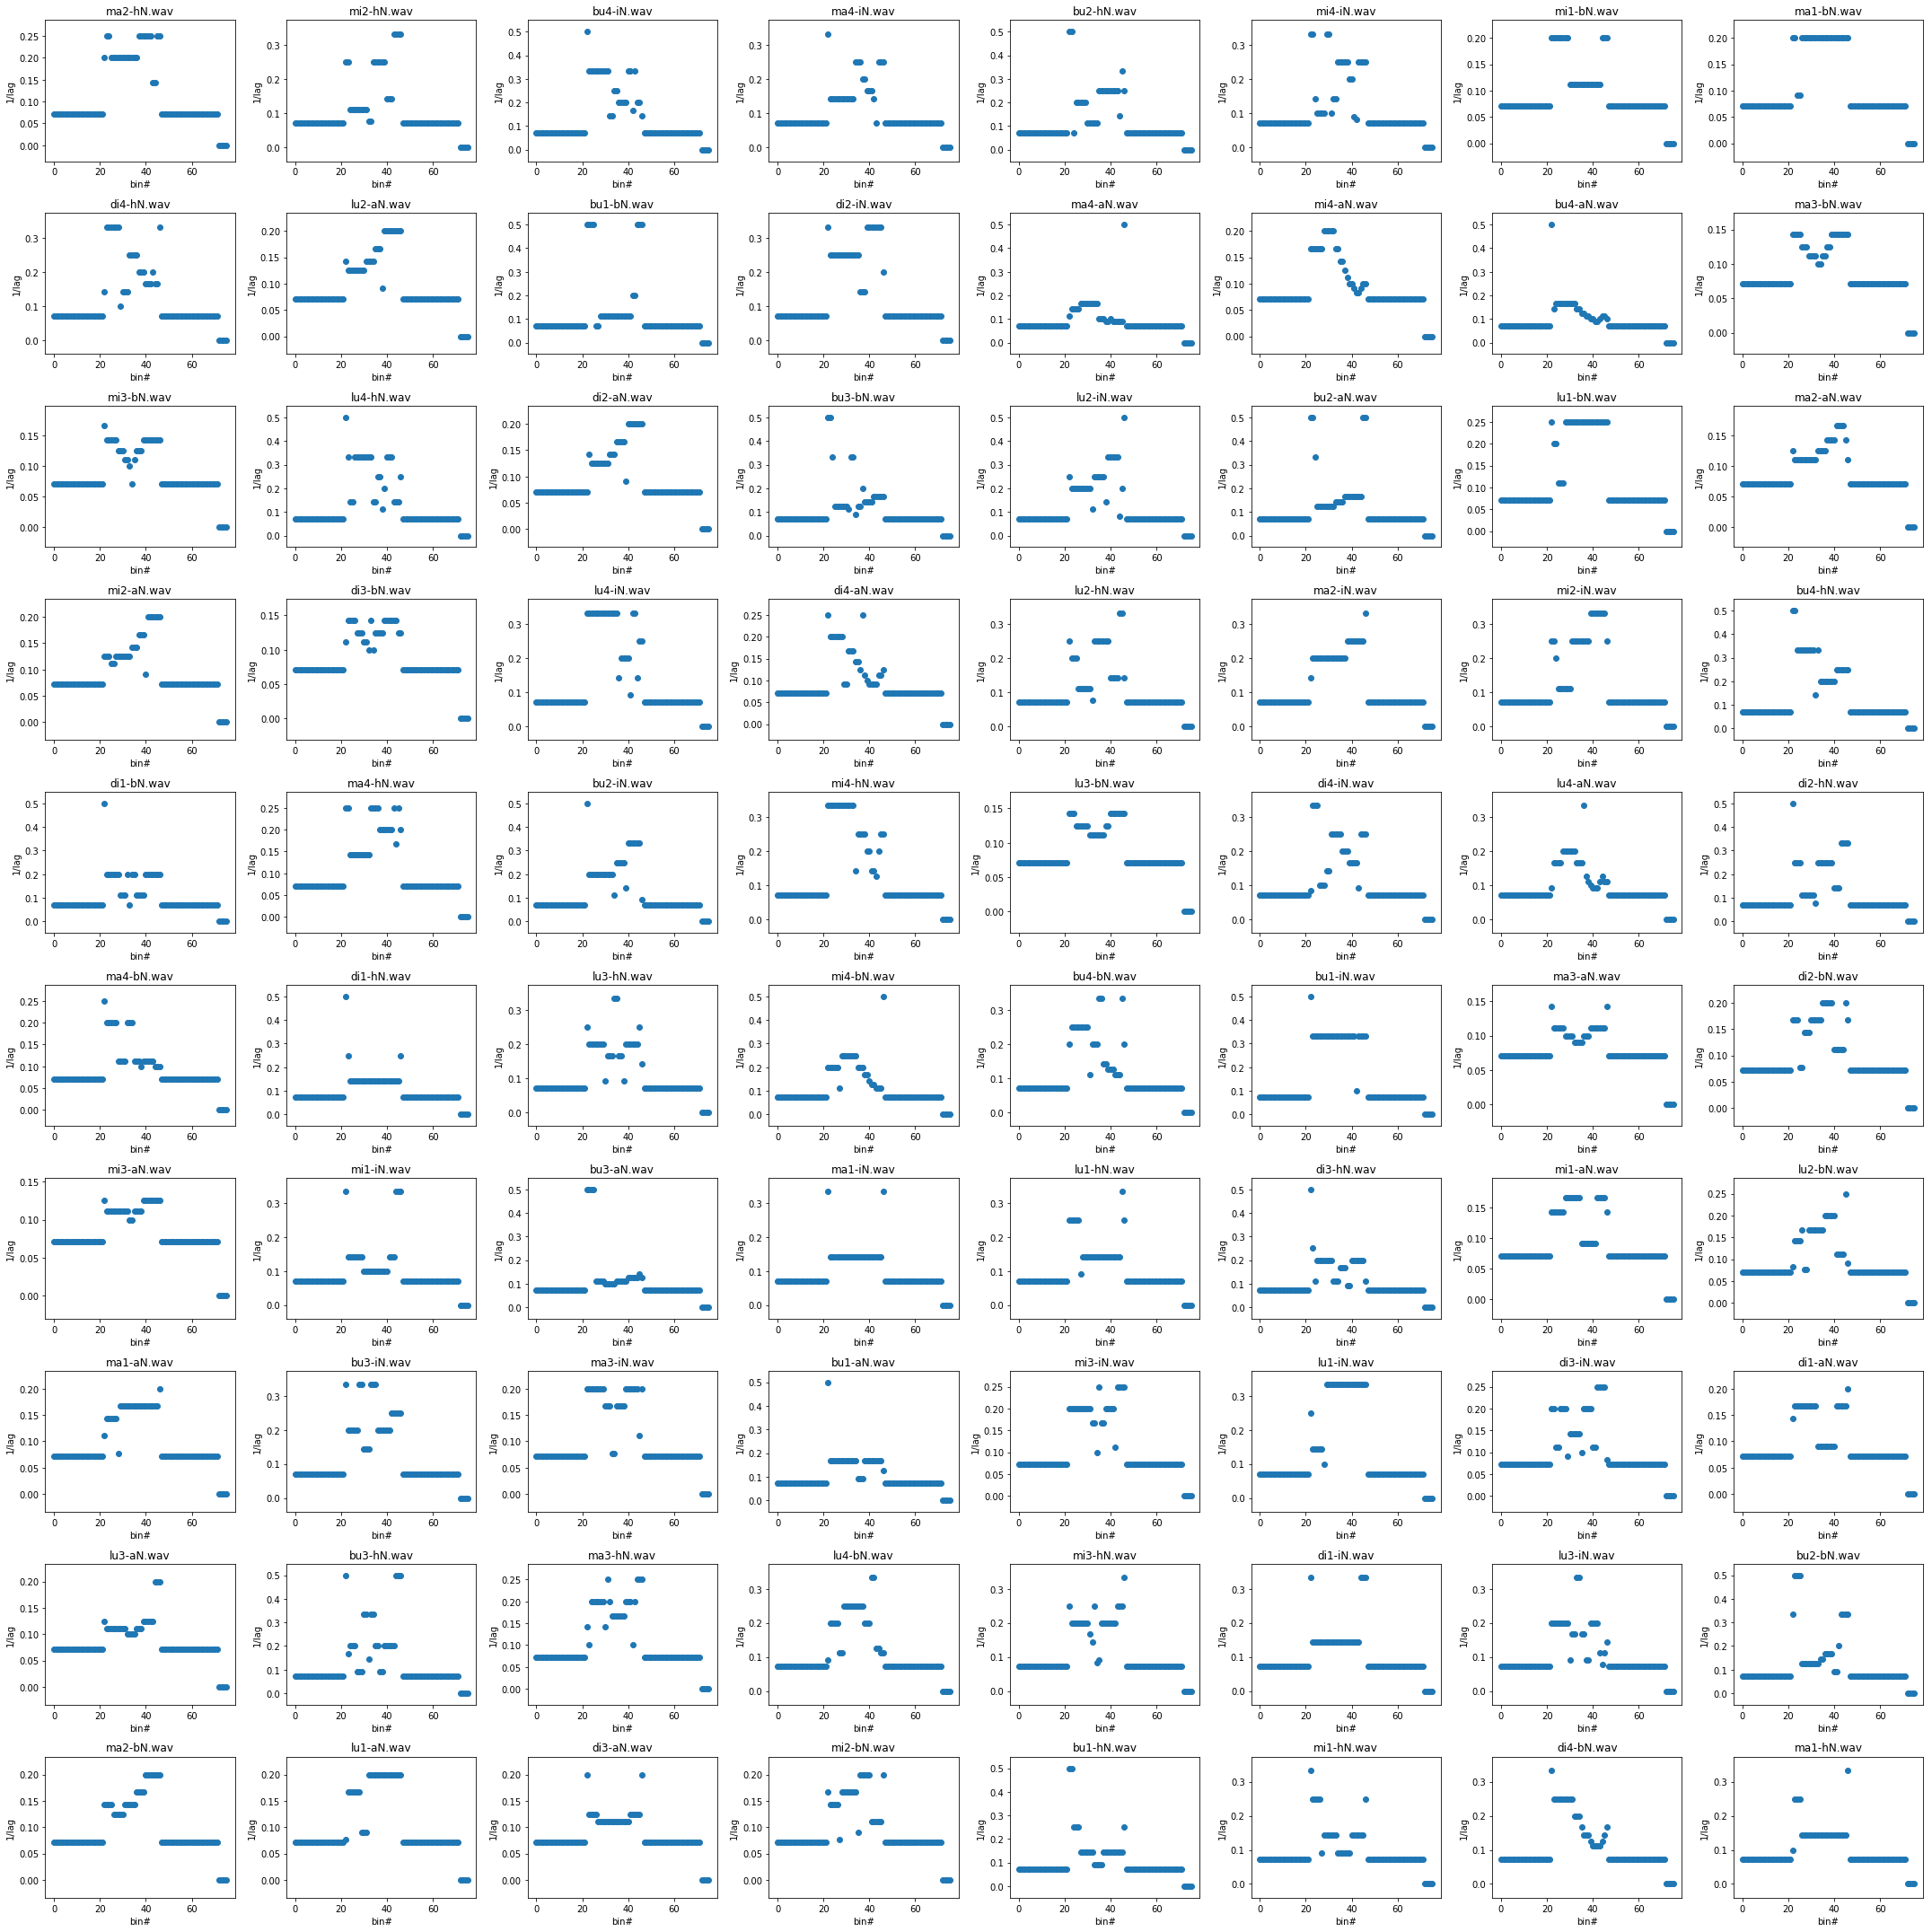

In [28]:
## Check to see if the plots look right
p = 1
fig = plt.figure(figsize = (30,30))
for i in dataLag:
    plt.subplot(10,8,p)
    plt.scatter(dataBin['bin'],dataLag[i])
    plt.title(i)
    plt.ylabel('1/lag')
    plt.xlabel('bin#')
    p += 1 
plt.tight_layout()
plt.show()

## Read FFR data and run autocorrelation

In [29]:
##Create overlaping time bins (80ms time bins overlaped by 20ms)
##this exports a dataframe for each trial, autocorrelated and normalized from -1 to 1
import pandas as pd
import itertools
import matplotlib as pyplot

dataFFR = pd.DataFrame()
dataLag = pd.DataFrame()
dataTest = pd.DataFrame()
data_all = pd.DataFrame()
test = np.where((behav['block'] < 22))[0]
# test.tolist()
# print(test)

# myhg = np.mean(hg_stim[myidx, :, 15], axis = 0)


for i in test:
    data_a = pd.DataFrame()
    file = behav['file'][i]
#     data[file] = np.zeros(23)
    myhg = hg_stim[i, :, 119]
#     print(len(myhg))
    start = -500 
    end = -420

    cor = np.zeros((72,81))
    d = np.zeros((72,81))
    dataLag = pd.DataFrame()
    dataLag[i] = np.zeros(76)

# #separate the data into times
    for x in range(0,72):
        index = np.where((time_axis <= end) & (time_axis >= start))[0]
        d[x,:] = myhg[index]
    #     d["bin{0}".format(x)]= myhg[index]
        end += 20
        start += 20


# data2 = pd.DataFrame()
# # do autocorr on all bins
    maxs = []
    lag = []
    for bins in range(0,d.shape[0]):
        cor[bins,:] = autocorr(d[bins,:]) ## run autocorrelation
    for bins in range(1,cor.shape[0]): 
        maxx = max(cor[bins][2:15]) ##find the max
        maxs.append(maxx) #add max to a list
        lags = np.where(cor[bins] == maxx) ##finding the lag
        lag.append(lags[0].tolist())
        for time in range(2,15):
                if cor[bins,time] == maxx:
                    dataLag[i][time] = 1/time

##Normalized from -1 to 1
    norms = []
    for m in maxs:
        high = max(maxs)
        low = min(maxs)
        n = 2*((m-low)/(high-low)) - 1
        norms.append(n)
    dataFFR[file + '_'+ str(i)] = norms
#     dataFFR[file + '_'+ str(i)] = maxs
    bins = [item for sublist in lag for item in sublist]
    lags = [1/x for x in bins]
    dataFFR['bin_' + str(i)] = bins
    dataFFR['lag_' + str(i)] = lags
    dataTest['bin_' + str(i)] = bins
    dataTest['lag_' + str(i)] = lags
    

dataFFR1 = dataFFR

## dataFFR is the FFR autocorr

/Users/alia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  


In [30]:
dataFFR

,bu2-bN_0,bin_0,lag_0,ma2-bN_1,bin_1,lag_1,ma4-bN_2,bin_2,lag_2,ma2-bN_3,...,lag_1657,bu4-hN_1658,bin_1658,lag_1658,bu2-hN_1659,bin_1659,lag_1659,bu3-bN_1660,bin_1660,lag_1660
0,-0.413287,9,0.111111,-0.556964,9,0.111111,-0.886803,11,0.090909,-0.785714,...,0.090909,0.386190,9,0.111111,-0.271343,11,0.090909,0.689332,10,0.100000
1,-0.195928,9,0.111111,-0.853652,9,0.111111,-0.700588,9,0.111111,-0.862108,...,0.090909,-0.384448,9,0.111111,-0.670511,11,0.090909,-0.058895,11,0.090909
2,-0.332978,9,0.111111,-0.732806,10,0.100000,-0.646243,9,0.111111,-0.850119,...,0.090909,-0.326895,9,0.111111,-0.572992,11,0.090909,-0.145329,9,0.111111
3,-0.356375,9,0.111111,-0.644139,10,0.100000,-0.890654,9,0.111111,-0.465847,...,0.076923,-0.602978,14,0.071429,-0.518991,13,0.076923,-0.142846,11,0.090909
4,-0.081380,7,0.142857,-0.840089,12,0.083333,-0.448549,9,0.111111,-0.731259,...,0.100000,-0.211015,14,0.071429,-0.670213,13,0.076923,-0.131664,12,0.083333
5,-0.275066,7,0.142857,-0.720360,11,0.090909,-0.095665,8,0.125000,-0.721227,...,0.100000,-0.283054,12,0.083333,-0.556515,13,0.076923,0.206640,11,0.090909
6,-0.505129,7,0.142857,-0.782193,12,0.083333,0.393927,9,0.111111,-0.780724,...,0.100000,-0.229693,11,0.090909,-0.292685,11,0.090909,-0.300212,11,0.090909
7,-0.522249,13,0.076923,-0.876367,13,0.076923,-0.282563,9,0.111111,-0.748534,...,0.111111,-0.430627,11,0.090909,-0.104028,11,0.090909,-0.630110,10,0.100000
8,-0.405661,9,0.111111,-0.820835,13,0.076923,0.268899,10,0.100000,-0.610543,...,0.076923,-0.963520,8,0.125000,-0.179393,11,0.090909,-0.420673,9,0.111111
9,-0.383531,9,0.111111,-0.753467,13,0.076923,-0.249540,10,0.100000,-0.536991,...,0.076923,-1.000000,8,0.125000,-0.191493,14,0.071429,-0.498859,9,0.111111


## Compare the peak autocorrelation for each trial

In [ ]:
test = np.where(behav['file'] == 'mi1-bN')
print(test)

In [15]:
## get list of tones
tones = np.unique(behav['file'])
tones = tones.tolist()

In [12]:
tones = ['bu1-bN', 'bu1-hN', 'bu3-hN', 'bu4-bN', 'di1-aN', 'ma1-aN', 'ma4-aN', 'ma4-bN', 'ma4-iN']

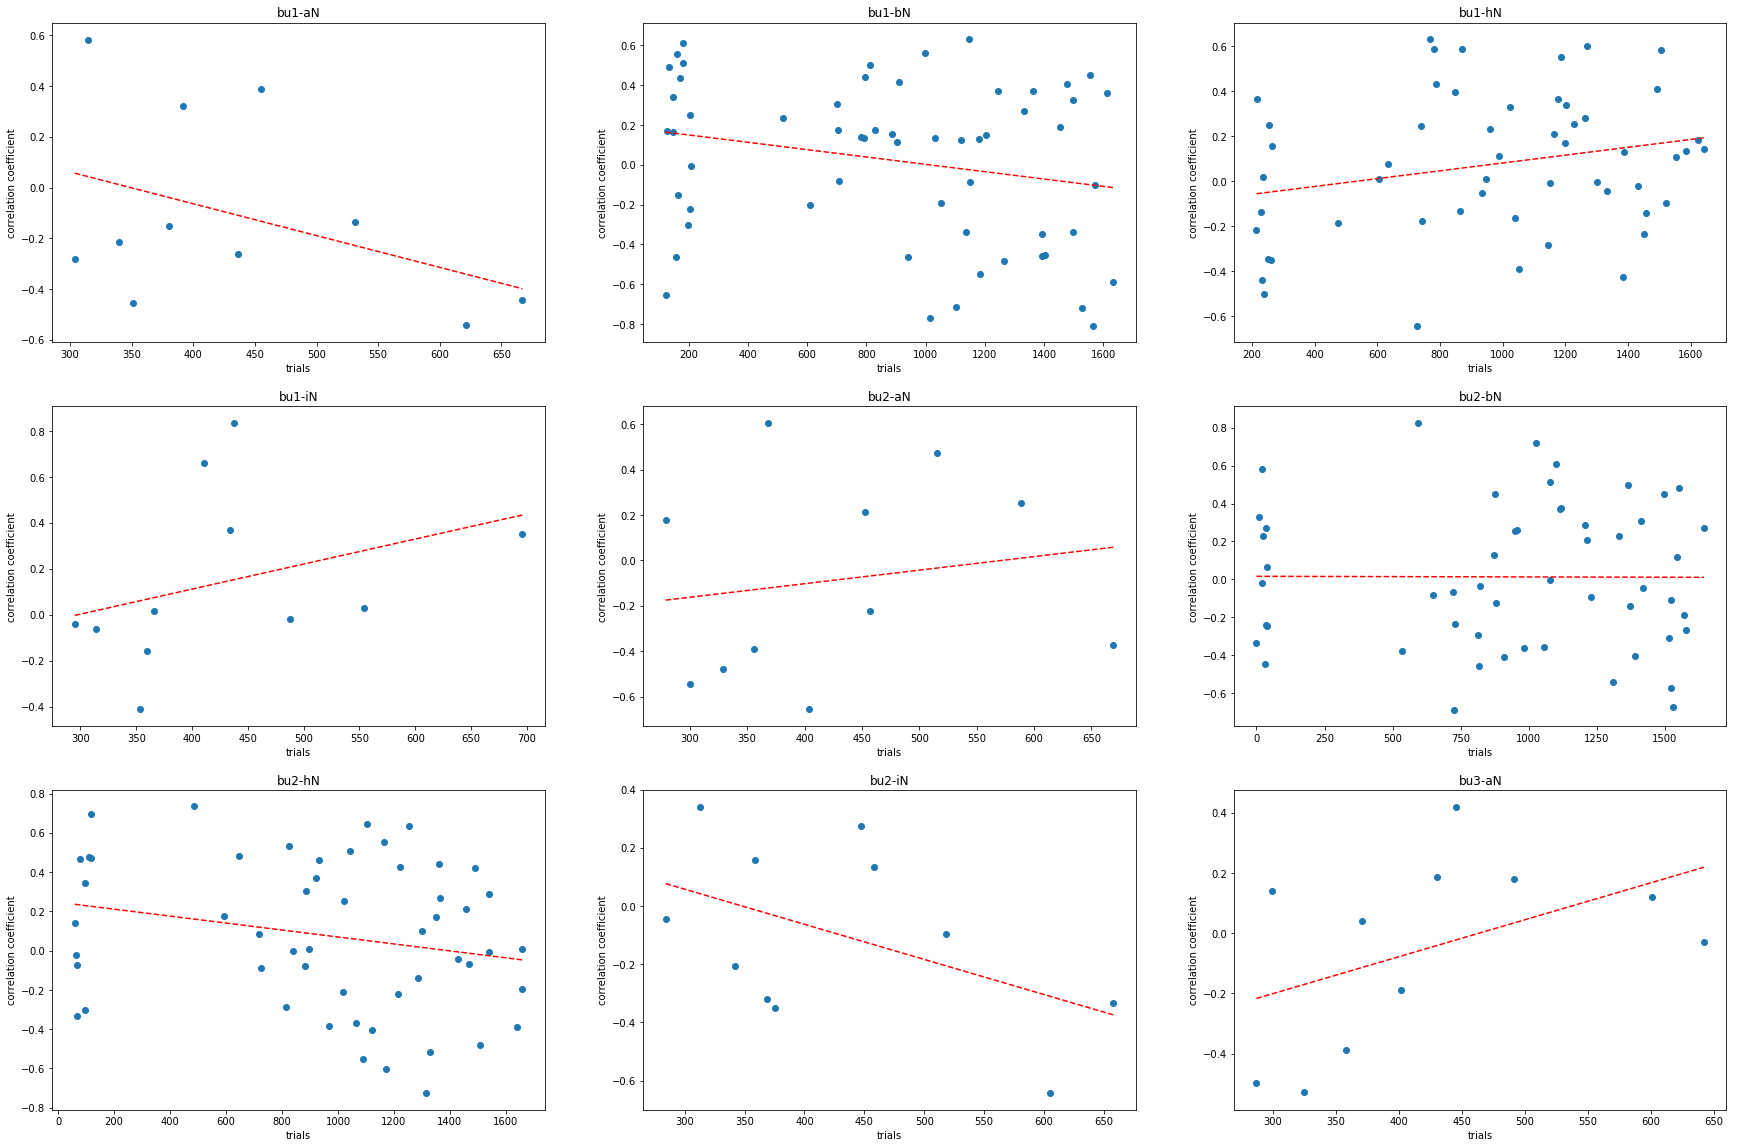

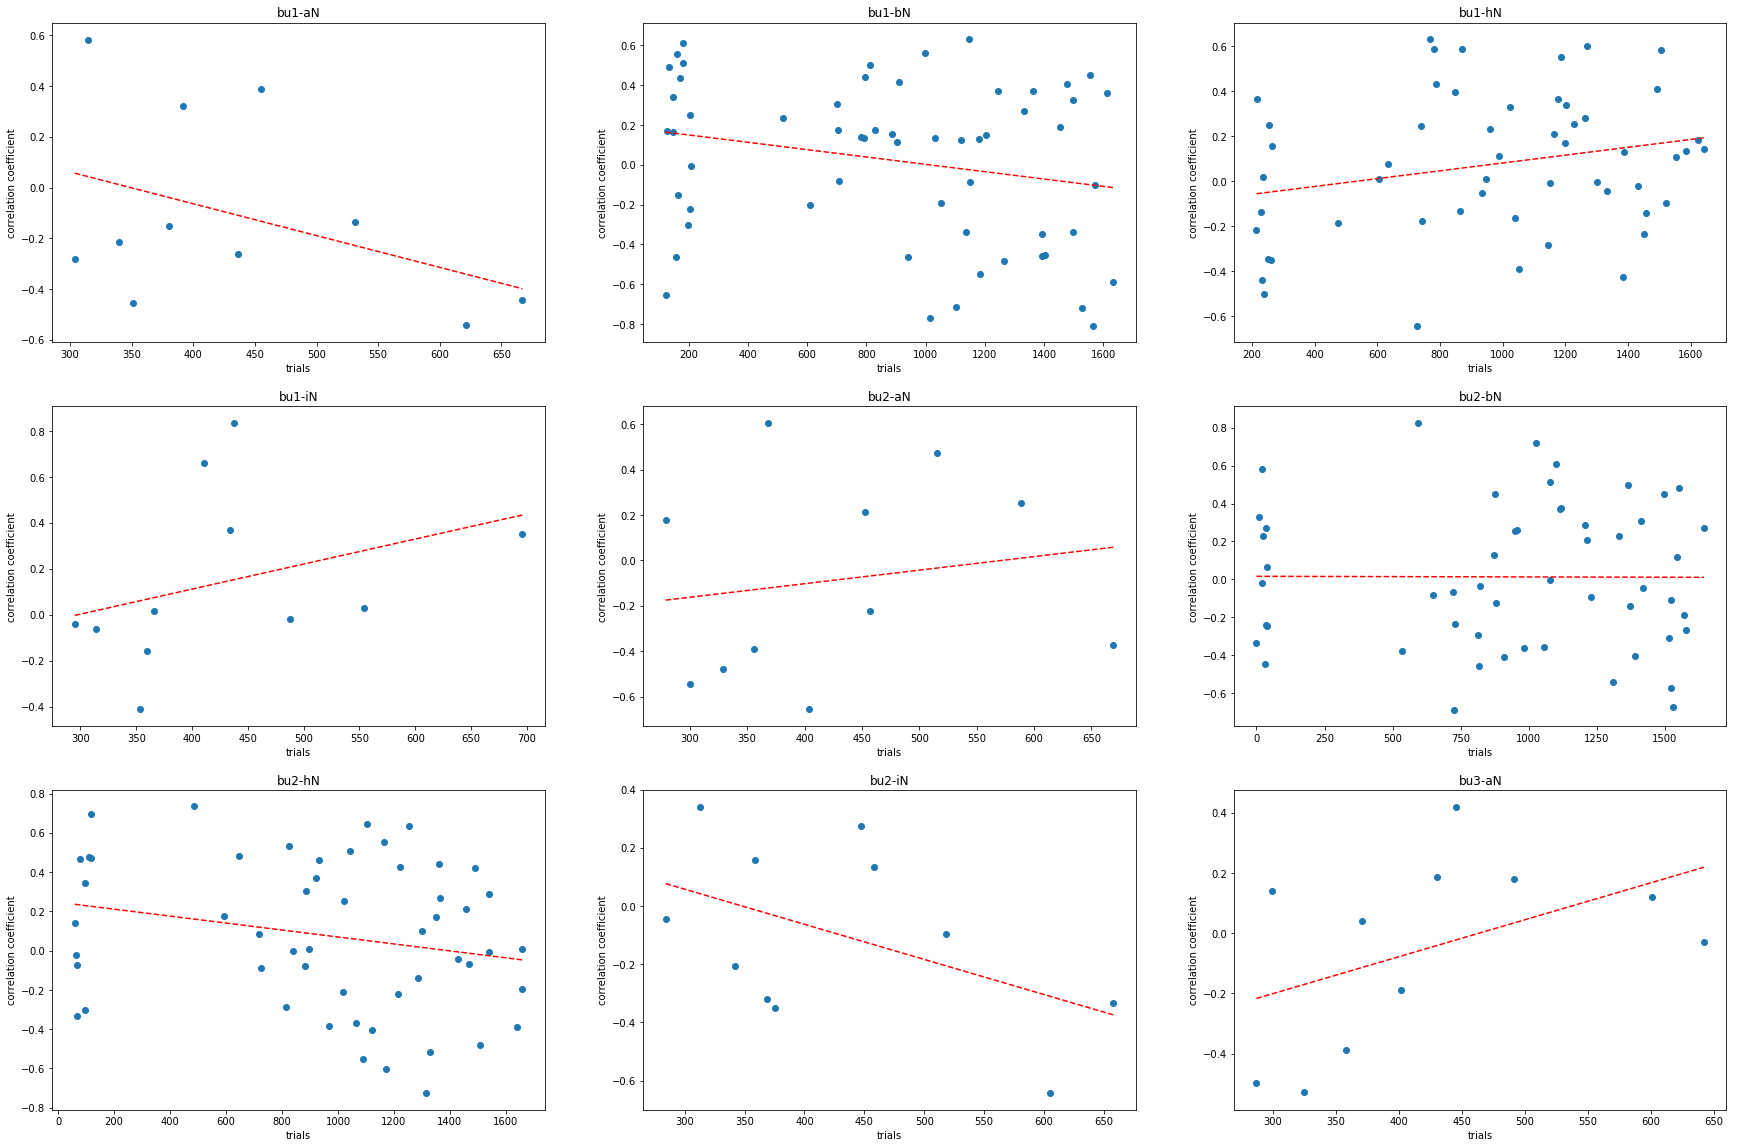

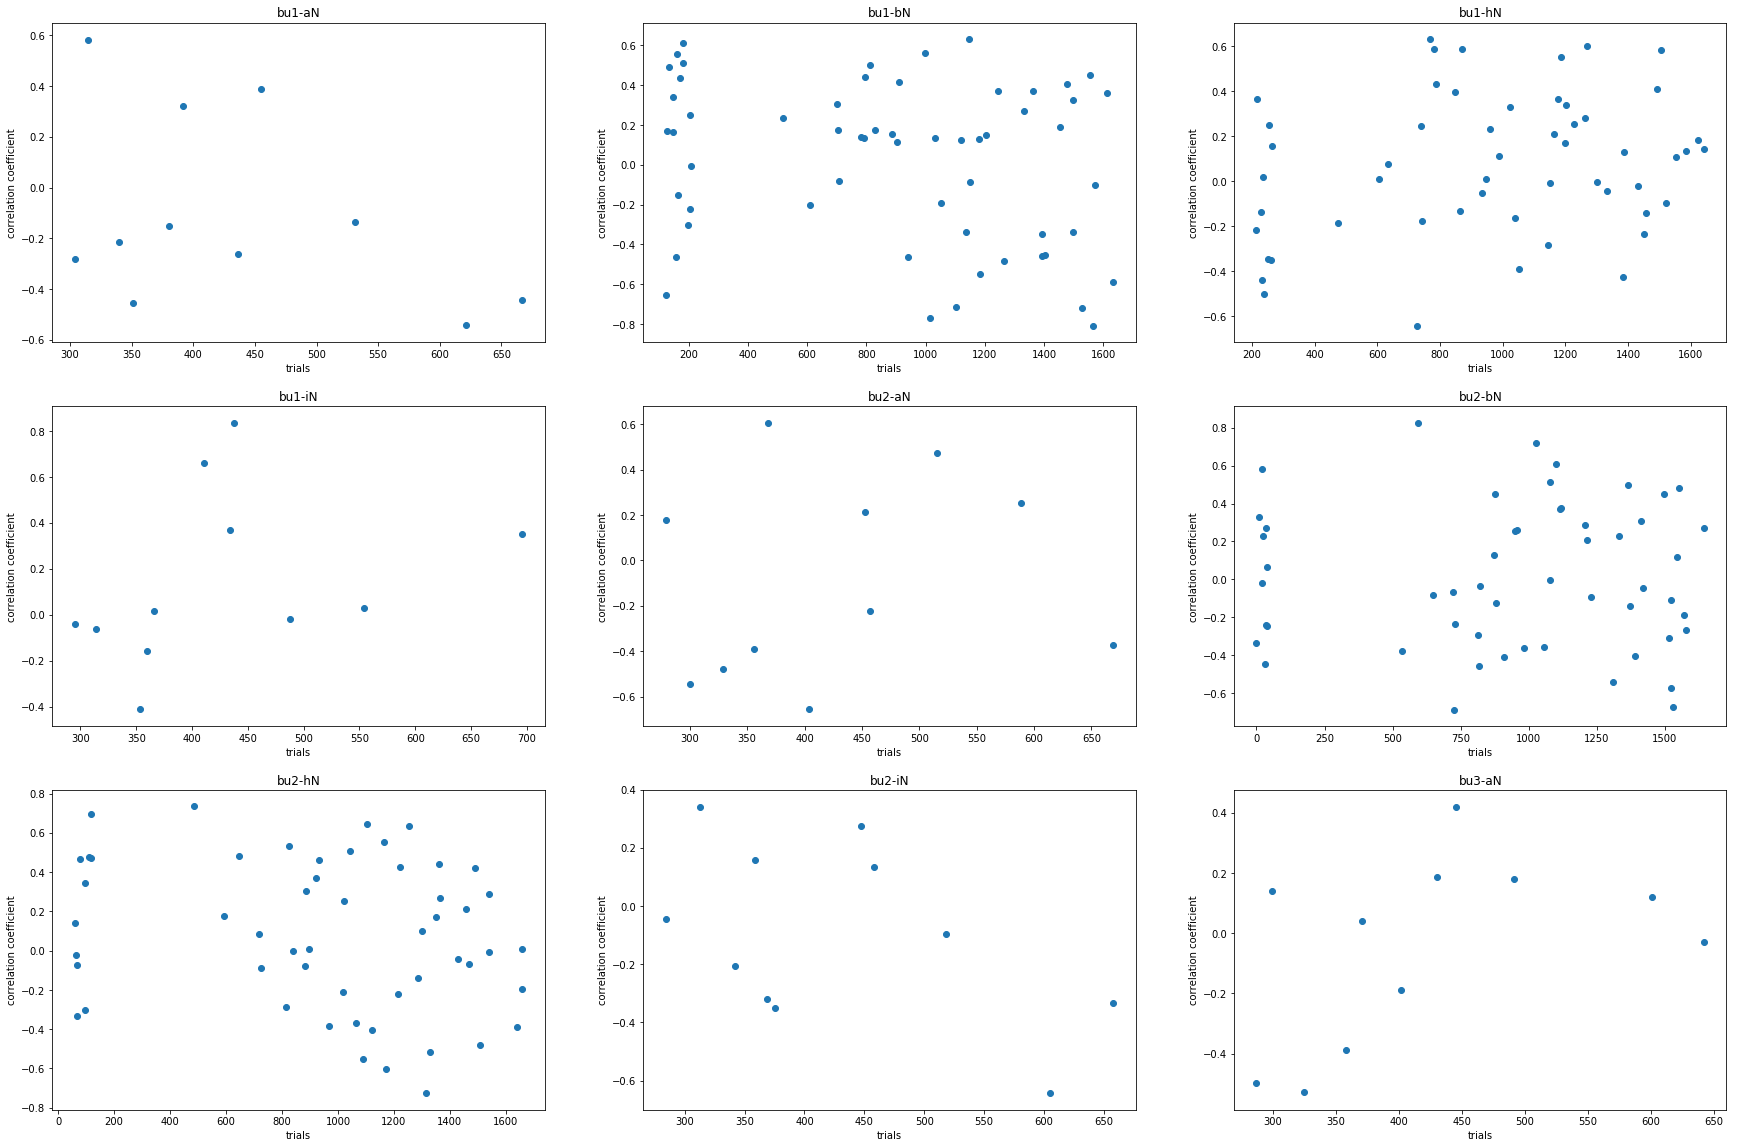

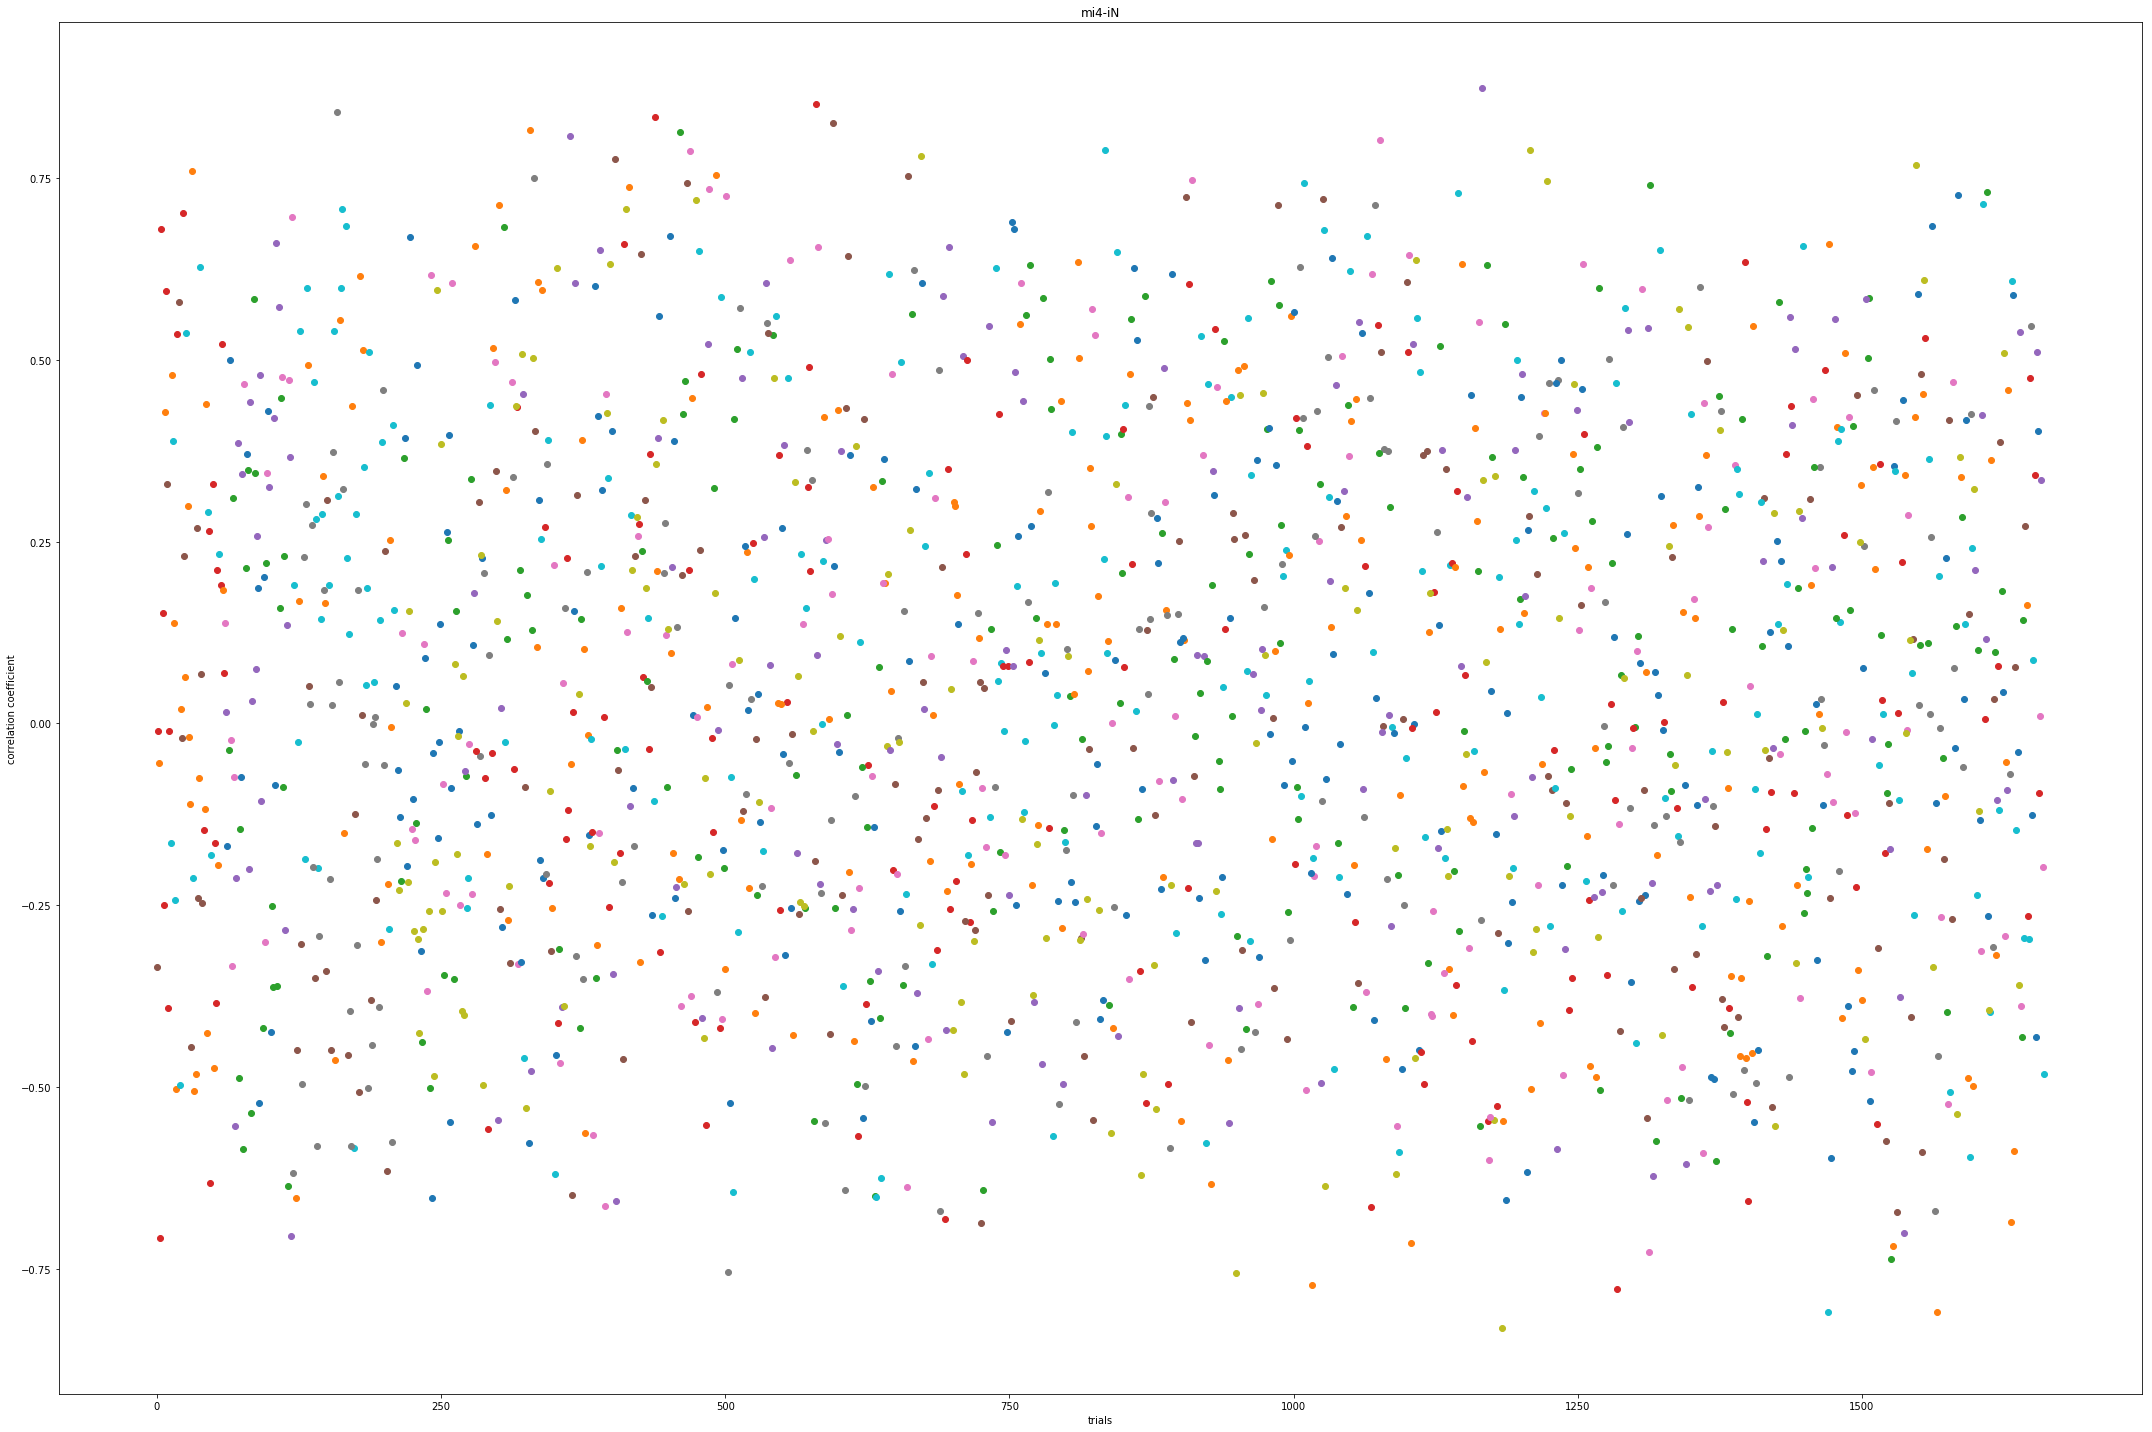

In [23]:
import statsmodels.api as sm
from scipy import stats

## read through the stim autocorr
'''data2 is the individual stim, dataFFR is the neural response'''
f = 1
l = 1
stats1 = pd.DataFrame()
stats1['stim'] = tones
# stats1['r_value'] = np.zeros(80)
# stats1['p_value'] = np.zeros(80)
# stats1['std_error'] = np.zeros(80)
# stats1['intercept'] = np.zeros(80)
# stats1['slope'] = np.zeros(80)

# stats1['r_value'] = np.zeros(9)
# stats1['p_value'] = np.zeros(9)
# stats1['std_error'] = np.zeros(9)
# stats1['intercept'] = np.zeros(9)
# stats1['slope'] = np.zeros(9)

fig = plt.figure(figsize = (30,20))
for t in tones:
    cors = []
    cors0 = []
    trials = []
    trials0 = []
    for j in data2:
        if j[0:6] == t:
            for i in dataFFR1:
                if j[0:5] in i:
                    cor = np.corrcoef(dataFFR1[i][22:46],data2[j][21:45])[0][1]
                    ##this elicits a trial x correlation coefficient 
                    cors.append(cor)
                    trials.append(int(i[7:len(i)]))
#             for g in dataFFR1:
#                 if j[0:5] in g:
#                     cor0 = np.corrcoef(dataFFR1[g][22:46],data2[j][21:45])[0][1]
#                     ##this elicits a trial x correlation coefficient 
#                     cors0.append(cor0)
#                     trials0.append(int(g[7:len(g)]) )  
#     print(trials)
#     plt.subplot(3,3,l)
#     lent = len(trials)
#     lenc = len(cors)
    plt.scatter(trials,cors)
#     z = np.polyfit(trials, cors, 1)
#     p = np.poly1d(z)
#     plt.plot(trials,p(trials),"r--")
#     slope, intercept, r_value, p_value, std_err = stats.linregress(trials,cors)
    
#     ## make table
#     for s in range(len(stats1['stim'])):
#         if stats1['stim'][s] == t:
#             stats1['r_value'][s] = r_value
#             stats1['p_value'][s] = p_value
#             stats1['std_error'][s] = std_err
#             stats1['intercept'][s] = intercept
#             stats1['slope'][s] = slope
    
    plt.title(t)
    plt.xlabel('trials')
    plt.ylabel('correlation coefficient')
    l += 1
plt.tight_layout()
plt.show()         
            
            

In [11]:
plt.show()

In [ ]:
stats1.to_csv('stats_response_correlation.csv')

In [ ]:
indx = np.where(stats1['p_value']<.05)

In [ ]:
stats_sig = stats1[stats1.p_value < .05]

In [ ]:
stats_sig.to_csv('stat_sig.csv')

In [ ]:
data = pd.DataFrame()
for stims in stats_sig['stim']:
    be = behav[behav.file == stims]
    a = be['accuracy'].value_counts(ascending=False)
    data[stims] = a
data

In [ ]:
stats_sig['percent_correct'] = np.zeros(len(stats_sig['stim']))
per = []
for d in data:
    t = data[d][1]/(data[d][0]+data[d][1])
    per.append(t)
stats_sig['percent_correct'] = per


In [ ]:
y = stats_sig['p_value']
plt.scatter(stats_sig['percent_correct'],y)
# z = np.polyfit(stats_sig['percent_correct'], y, 1)
# p = np.poly1d(z)
# plt.plot(stats_sig['percent_correct'],p(stats_sig['percent_correct']),"r--")
plt.ylabel('p values')
plt.xlabel('percent correct')
plt.title('p value vs percent correct')
slope, intercept, r_value, p_value, std_err = stats.linregress(stats_sig['percent_correct'],y)

In [ ]:
plt.show()

In [ ]:
stats_sig

## Which trials were correct, which were incorrect?

In [ ]:
# for v in stats_sig['stim']:
#     R = np.where((behav['file'] == v) & (behav['accuracy'] == 1))
#     W = np.where((behav['file'] == v) & (behav['accuracy'] == 0))

### Plot correct vs incorrect on the same graph

In [ ]:
dataFFR_1 = dataFFR1
dataFFR_0=dataFFR0
import statsmodels.api as sm
from scipy import stats

## read through the stim autocorr
'''data2 is the individual stim, dataFFR is the neural response'''
f = 1
l = 1
plts = 1
stats1 = pd.DataFrame()
stats1['stim'] = tones

stats1['r_value'] = np.zeros(9)
stats1['p_value'] = np.zeros(9)
stats1['std_error'] = np.zeros(9)
stats1['intercept'] = np.zeros(9)
stats1['slope'] = np.zeros(9)



fig = plt.figure(figsize = (30,20))
for t in tones:
    cors = []
    cors0 = []
    trials = []
    trials0 = []
    all_data = pd.DataFrame()
    for j in data2:
        if j[0:6] == t:
            for i in dataFFR_1:
                if j[0:5] in i:
                    cor = np.corrcoef(dataFFR_1[i][24:48],data2[j][21:45])[0][1]
                    ##this elicits a trial x correlation coefficient 
                    cors.append(cor)
                    trials.append(int(i[7:len(i)]))
            for g in dataFFR_0:
                if j[0:5] in g:
                    cor0 = np.corrcoef(dataFFR_0[g][24:48],data2[j][21:45])[0][1]
                    ##this elicits a trial x correlation coefficient 
                    cors0.append(cor0)
                    trials0.append(int(g[7:len(g)]))  
    lent = len(trials)
    lenc = len(cors)
    trial2 = [trials.append(c) for c in trials0]
    cors2 = [cors.append(f) for f in cors0]
    all_data['accuracy'] = np.zeros(len(cors))
    all_data['trials'] = trials
    all_data['cors'] = cors
    for a in range(0,lent):
        all_data['accuracy'][a] = 'red'
    for b in range(lent,len(all_data['trials'])):
        all_data['accuracy'][b] = 'blue'
        
    all_data = all_data.sort_values(by = ['trials'])
    plt.subplot(3,3, plts)
    plt.scatter(all_data['trials'], all_data['cors'], c = all_data['accuracy'])
    plts+=1

    plt.title(t, fontsize = 15)
    plt.xlabel('trials', fontsize = 15)
    plt.ylabel('correlation coefficient',fontsize = 15)
    l += 1
plt.tight_layout()
plt.show()         

### Peak Autocorr x Trial

In [ ]:
maxs = pd.DataFrame()
m = []
mS = []
for d in dataFFR:
    if len(d) > 8:
        m.append(max(dataFFR[d][21:45]))

for c in data2:
    mS.append(max(data2[c][21:45]))

In [ ]:
fig = plt.figure(figsize = (30,20))
tones = np.unique(behav['file'])
plts = 1
idx1 = []
for t in tones:
    cors = []
    cors0 = []
    trials = []
    trials0 = []
    idx = []
    all_data = pd.DataFrame()
    for j in data2:
        if j[0:6] == t:
            for i in dataFFR:
                if j[0:5] in i:
                    cor = (max(dataFFR[i][21:45])-max(data2[j][21:45]))
                    ##this elicits a trial x correlation coefficient 
                    cors.append(cor)
                    trials.append(int(i[7:len(i)]))
    print(min(cors))
#     for x in range(len(trials)):
#         if cors[x] == 0.0:
#             idx.append(int(trials[x]))
#     if len(idx) >0:
#         idx1.append(min(idx))
    plt.subplot(8,10, plts)
    plt.scatter(trials,cors)
    plt.title(t, fontsize = 15)
    plt.xlabel('trials', fontsize = 15)
    plt.ylabel('Difference',fontsize = 15)
    plts+=1
# av = sum(idx1)/len(idx1)
# print(av)
plt.tight_layout()
plt.show()

In [ ]:
dataFFR

In [ ]:
##Create overlaping time bins (80ms time bins overlaped by 20ms)
##this exports a dataframe for each trial, autocorrelated and normalized from -1 to 1
import pandas as pd
import itertools
import matplotlib as pyplot

dataFFR = pd.DataFrame()
dataLag = pd.DataFrame()

test = np.where((behav['block'] < 22)& (behav['file'] == 'ma1-aN'))[0]
# test.tolist()
# print(test)

# myhg = np.mean(hg_stim[myidx, :, 15], axis = 0)


for i in test:
    file = behav['file'][i]
#     data[file] = np.zeros(23)
    myhg = hg_stim[i, :, 119]
#     print(len(myhg))
    start = -500 
    end = -420

    cor = np.zeros((72,81))
    d = np.zeros((72,81))
    dataLag = pd.DataFrame()
    dataLag[i] = np.zeros(76)

# #separate the data into times
    for x in range(0,72):
        index = np.where((time_axis <= end) & (time_axis >= start))[0]
        d[x,:] = myhg[index]
    #     d["bin{0}".format(x)]= myhg[index]
        end += 20
        start += 20

# data2 = pd.DataFrame()
# # do autocorr on all bins
    maxs = []
    lag = []
    for bins in range(0,d.shape[0]):
        cor[bins,:] = autocorr(d[bins,:]) ## run autocorrelation
#         print(cor[bins,:])
        f,t, Sxx = signal.spectrogram(cor[bins,:], 1000, noverlap = 76, nperseg =90)
        plt.pcolormesh(t, f, Sxx)    
        plt.show()

dataFFR_0 = dataFFR

## dataFFR is the FFR autocorr

## Plot 1/lag vs time 

In [ ]:
x = time
y = dataFFR['lag_6'][25:50]

ax = plt.plot(x,y)

In [ ]:
tone1 = []
tone2 = []
tone3 = []
tone4 = []
for t in tones:
    if '1' in t:
        tone1.append(t)
    if '2' in t:
        tone2.append(t)
    if '3' in t:
        tone3.append(t)
    if '4' in t:
        tone4.append(t)
tonesT = []
tonesT.append(tone1)
tonesT.append(tone2)
tonesT.append(tone3)
tonesT.append(tone4)

tonesT = [item for sublist in tonesT for item in sublist]




In [ ]:
fig = plt.figure(figsize = (30,20))
tones = np.unique(behav['file'])
plts = 1
idx1 = []
for t in tonesT:
    cors = []
    cors0 = []
    trials = []
    trials0 = []
    idx = []
    all_data = pd.DataFrame()
    for j in data2:
        if j[0:6] == t:
            for i in dataFFR:
                if j[0:5] in i:
                    b = i[6:len(i)]
                    x = time
                    y = dataFFR['lag' + b][25:50]
                    plt.plot(x,y, color='skyblue', alpha = .7)
    plt.subplot(8,10, plts)
    plt.title(t, fontsize = 15)
    plt.xlabel('time', fontsize = 15)
    plt.ylabel('1/lag',fontsize = 15)
    plts+=1
    plt.title(t)
plt.tight_layout()
plt.show()
                    

In [ ]:
time = list(range(-500,1000,20))

In [ ]:
time = list(range(0,500,20))

In [ ]:
len(time)

In [ ]:
len(dataFFR['lag_0'][25:50])

In [ ]:
len(dataFFR['lag_0'][25:50])

## Use Librosa to automate pitch

In [15]:
import sys
def detect_pitch(y, sr, t):
    magnitudes[magnitudes == 0] = 'NaN'
    try:
        index = np.nanargmin(magnitudes[:, t])
        pitch = pitches[index, t]
    except Exception as e: 
        print('error')
        pitch = 0
        
    return pitch

In [ ]:
y, sr= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + 'bu4-bN.wav', sr = 1000) ##changes the sr to 1000
pitches, magnitudes = librosa.piptrack(y, sr = 1000, n_fft = 40, hop_length = 20, fmin = 100, fmax = 400)

In [ ]:
tones = np.unique(behav['file'])
print(tones)

In [ ]:
##Create overlaping time bins (80ms time bins overlaped by 20ms)
##this exports a dataframe for each trial, autocorrelated and normalized from -1 to 1
import pandas as pd
import itertools
import matplotlib as pyplot
import librosa

test = np.where((behav['block'] < 22))[0]
time = list(range(38))
datam = pd.DataFrame()
datap = pd.DataFrame()
for i in test:
    file = behav['file'][i]
    mm = []
    pp = []
    myhg = hg_stim[i, :, 119]
    pitches, magnitudes = librosa.piptrack(myhg, sr = 1000, n_fft = 40, hop_length = 20, fmin = 200, fmax = 400)
#     for t in time:
#         pit = detect_pitch(myhg, 1000, t)
    mm.append(magnitudes)
    pp.append(pitches)
    datam[str(file) + '_'+ str(i)] = mm
    datap[str(file) + '_'+ str(i)] = pp

In [ ]:
aim = np.zeros((21,76))
aip = np.zeros((21,76))
for i in data:
    if 'bu2-bN' in i:
#         print(i)
        im = datam[i][0]
        aim = aim + im
        
        ip = datap[i][0]
        aip = aip + ip

In [ ]:
plt.imshow(aim, origin = 'lower', vmin = np.percentile(aim, 80))
plt.show()

In [ ]:
magnitudes = magnitudes

In [ ]:
# data_bin = pd.DataFrame()
for n in range(magnitudes.shape[0]):
    nums = []
    for m in range(magnitudes.shape[1]):
        if str(magnitudes[n][m]) != 'nan':
            nums.append(magnitudes[n][m])
    if len(nums) > 0:
        thresh = np.percentile(nums, [90, 95, 100])
#         print(thresh[0])


            

## Use librosa to calculate pitch

In [16]:
import os
dirs = os.listdir('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/')

positive = np.zeros((558,))
negative = np.zeros((500,))

data2 = pd.DataFrame()
time = list(range(23))
# print(d.shape)
# for i in dirs:
for i in dirs:
    y, sr= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000) ##changes the sr to 1000
    pitches, magnitudes = librosa.piptrack(y, sr = 1000, n_fft = 40, hop_length = 20, fmin = 100, fmax = 400)
    threshold = {}
#     print(pitches.shape)
#     print(i)
#     print(pitches)
    for n in range(pitches.shape[0]):
        nums = []
        for m in range(pitches.shape[1]):
            if str(pitches[n][m]) != 'nan':
                nums.append(pitches[n][m])
            if len(nums) > 0:
                thresh = np.percentile(nums, [90, 95, 100])
                threshold[str(i[0:6])+'_' + str(n)] = thresh[0]
                p = []
                for t in time:
                    pit = detect_pitch(y, 1000, t)
                    if pit < thresh[0]:
#                         print(thresh[0])
                        p.append('nan')
#                         print('nan')
                    else:
                        p.append(pit)
#                 print(len(p))
                data2[str(i)] = p
        
data2              
   


error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
erro

,ma2-hN.wav,mi2-hN.wav,bu4-iN.wav,ma4-iN.wav,bu2-hN.wav,mi4-iN.wav,mi1-bN.wav,ma1-bN.wav,di4-hN.wav,lu2-aN.wav,...,lu3-iN.wav,bu2-bN.wav,ma2-bN.wav,lu1-aN.wav,di3-aN.wav,mi2-bN.wav,bu1-hN.wav,mi1-hN.wav,di4-bN.wav,ma1-hN.wav
0,304.501709,303.752991,207.943161,350.812866,346.568634,249.641220,351.474060,300.566742,314.853516,172.020050,...,298.949738,172.406525,315.774475,351.402191,279.724792,271.249329,233.308716,328.499115,109.597527,287.360657
1,231.780853,227.828049,314.456055,280.152008,296.665070,298.658966,185.395096,372.986542,244.086807,368.434814,...,202.426666,263.575623,293.140045,163.650970,322.481171,297.388428,221.875916,263.796661,130.739578,268.398590
2,237.965759,223.502335,321.919312,276.857544,351.916107,295.808899,372.925720,360.910828,143.066025,375.026367,...,379.743164,0.000000,271.181854,323.576904,357.488892,293.458527,329.327850,256.389648,235.228760,267.628998
3,351.969971,221.637939,324.271057,275.155304,197.482101,297.798798,383.170776,365.872711,309.092499,372.210419,...,195.128540,348.281433,265.089447,326.450714,353.234772,296.374084,276.167389,270.375549,237.417786,274.175751
4,197.194748,225.461395,325.813934,276.020233,201.930450,300.115204,198.250565,381.867218,306.838257,375.877869,...,197.385269,381.950531,261.930359,342.270874,349.182556,303.288605,278.372681,275.062439,240.246857,280.785400
5,198.583313,222.550980,325.255524,285.174316,209.276443,300.493683,202.912415,195.173309,303.828186,374.155884,...,191.476837,251.011200,260.102509,351.199066,345.097534,313.760223,279.362427,275.182129,241.195923,279.941467
6,200.203094,223.225571,321.074646,293.775909,219.540573,302.399353,215.412903,198.620956,301.149017,381.978394,...,181.840073,125.078056,259.209778,357.328461,341.271301,320.654327,278.320404,276.733063,238.915695,280.338318
7,201.041779,225.197388,309.910400,290.505615,220.130890,309.726288,217.958542,200.931519,296.201202,258.194641,...,175.883438,243.493332,264.744110,363.163300,331.623413,325.464417,277.556641,277.461823,232.911926,279.667755
8,200.818375,227.344177,300.578857,289.519836,220.199280,304.031677,219.454910,201.823471,289.738739,268.284637,...,174.743805,123.697357,270.695618,371.606750,323.801453,329.013092,276.865631,277.927368,226.260651,280.503326
9,201.864487,228.923645,290.782623,284.055450,220.450455,299.628510,220.267960,201.606827,281.633453,275.017181,...,225.068481,125.310295,275.338165,376.598358,318.037598,333.743408,275.599121,277.204651,216.317200,281.621185


In [ ]:
# np.where(data2 == 'nan')

In [ ]:
data2

In [ ]:
plt.plot(data2['bu1-hN.wav'])
plt.show()

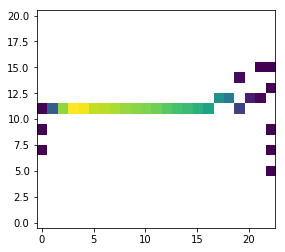

In [22]:
plt.imshow(magnitudes, origin = 'lower')
plt.show()
# plt.imshow(magnitudes, origin = 'lower', fmin = 200)
# plt.show()
# print(i)

In [ ]:
# plt.hist(magnitudes, 2)
plt.show()

print(np.percentile(magnitudes, [90, 95, 100]))

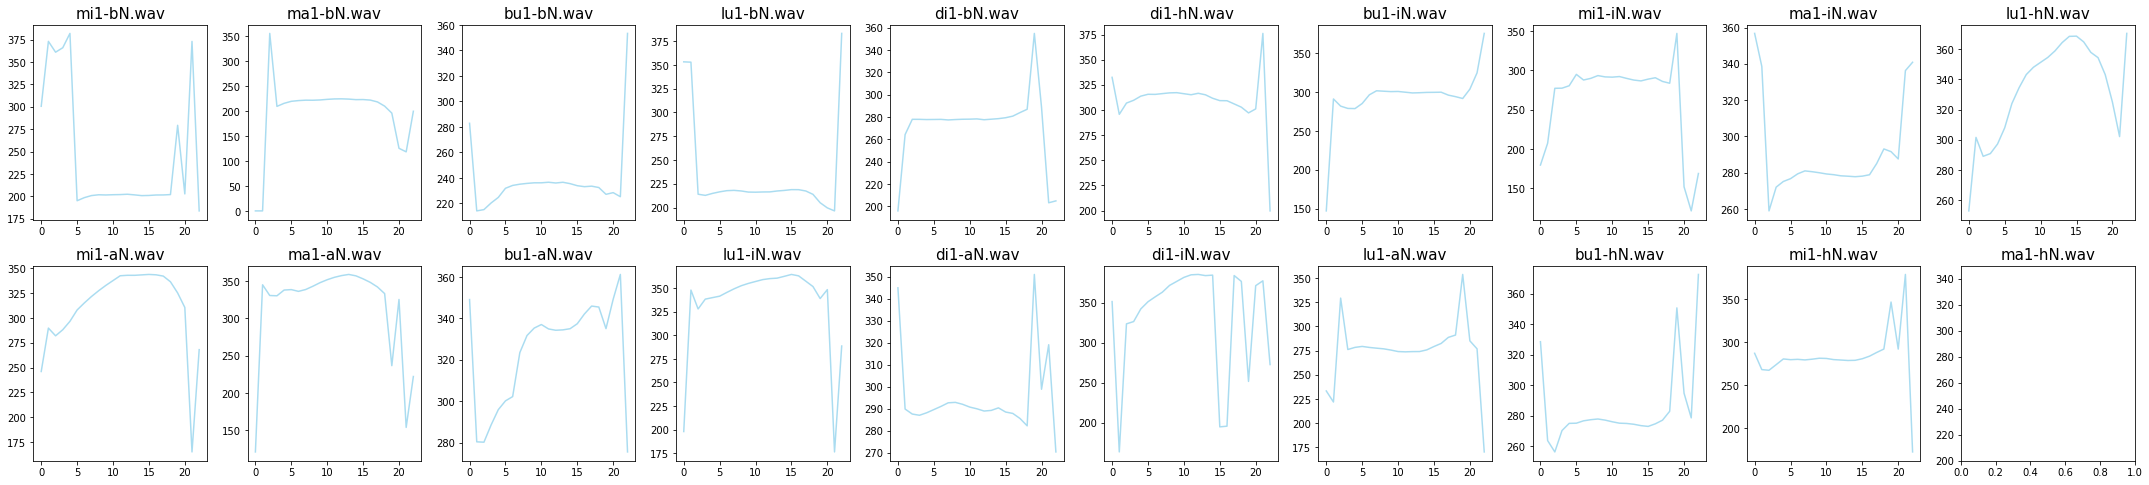

In [21]:
fig = plt.figure(figsize = (30,20))
plts = 1
for d in data2:
    if '1' in d:
        plt.plot(data2[d], color='skyblue', alpha = .7)
        plt.subplot(6,10, plts)
        plt.title(d, fontsize = 15)
        plts+=1
plt.tight_layout()
plt.ylim(200,350)
plt.show()



In [ ]:
fig = plt.figure(figsize = (30,20))
plts = 1
for ts in tones:
    data_t = pd.DataFrame()
    for d in data2:
        if ts == d[0:6]:
            plt.plot(data2[d], color='skyblue', alpha = .7)
    plt.subplot(8,10, plts)
    plt.title(ts, fontsize = 15)
    plts+=1
plt.tight_layout()
plt.ylim(100,500)
plt.show()


In [ ]:
test = []
myhg = hg_stim[1, :, 15]
pitches, magnitudes = librosa.piptrack(myhg, n_fft = 75)
time = list(range(75))
for i in time:
    t = detect_pitch(myhg, 1000, i)
    test.append(t)
plt.plot(test)
plt.show()

In [ ]:
tones = np.unique(behav['file'])
tones

In [ ]:
dirs = os.listdir('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/')
positive = np.zeros((558,))
negative = np.zeros((500,))

data2 = pd.DataFrame()
dataLag = pd.DataFrame()
# dataLag['1/lag'] = np.zeros(76)
# dataLag['max'] = np.zeros(76)

# print(d.shape)
for i in dirs:
    y, sr= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000) ##changes the sr to 1000
    a= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000) ##changes the sr to 1000
    y = np.append(y,positive)
    y = np.insert(y,0,negative)
    pitches,magnitudes = librosa.piptrack(y,1000)

In [ ]:
plt.scatter(magnitudes, pitches)

In [ ]:
plt.show()

## Find delay time

In [28]:
for i in data2:
    for j in dataFFR:
        if i[:-4] in j:
            cor = []
            for m in dataFFR[j]:
                for n in data2[i]:
                    test = np.correlate(m,n)
                    cor.append(test)
           

-0.152600728665


ValueError: object of too small depth for desired array